In [32]:
import os
new_dir = '/home/ma/ma_ma/ma_tofuchs/Interpretable-Deep-Fake-Detection/results'
if os.path.exists(new_dir):
    os.chdir(new_dir)
    print("Changed working directory to:", os.getcwd())
else:
    print("Directory does not exist")

Changed working directory to: /pfs/data6/home/ma/ma_ma/ma_tofuchs/Interpretable-Deep-Fake-Detection/results


In [33]:
from matplotlib.colors import LinearSegmentedColormap
import os
import pickle
import matplotlib.pyplot as plt
import uuid
import numpy as np
import torch

In [34]:
# Adjust the path: go up two levels from the current working directory to the project root.
results_file = os.path.join( "resnet34_bcos_v2_minimal_test_MPG_config","MaskPointingGame",
                            "results_by_threshold.pkl")

#Interpretable-Deep-Fake-Detection/results/resnet34_bcos_v2_minimal_test_MPG_config
print("Results file path:", os.path.abspath(results_file))

Results file path: /pfs/data6/home/ma/ma_ma/ma_tofuchs/Interpretable-Deep-Fake-Detection/results/resnet34_bcos_v2_minimal_test_MPG_config/MaskPointingGame/results_by_threshold.pkl


In [108]:
def visualize_MPG(img_np, mask, explanation_map, axes, row_idx, weighted_accuracy, unweighted_accuracy, threshold, resolution=256):
    """Visualize Model Prediction Guided (MPG) explanation."""
    if isinstance(explanation_map, torch.Tensor):
        explanation_map = explanation_map.cpu().numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    # Original image
    axes[row_idx, 0].imshow(img_np, extent=(0, resolution, 0, resolution))
    axes[row_idx, 0].set_xticks([])
    axes[row_idx, 0].set_yticks([])

    if mask.max() > 0.1:
        mask_np = np.array(mask * 255)

        # Mask
        axes[row_idx, 1].imshow(mask_np, extent=(0, resolution, 0, resolution))
        axes[row_idx, 1].set_title(f"Weighted/Un Acc {weighted_accuracy:.2f}, {unweighted_accuracy:.2f}")
        axes[row_idx, 1].set_xticks([])
        axes[row_idx, 1].set_yticks([])

        # Explanation + Mask overlay
        axes[row_idx, 2].imshow(explanation_map, extent=(0, resolution, 0, resolution))
        axes[row_idx, 2].imshow(mask_np, cmap='jet', alpha=0.5, extent=(0, resolution, 0, resolution))
        #axes[row_idx, 2].set_title(f"Weighted/Un Acc {weighted_accuracy.round(2)}, {unweighted_accuracy.round(2)}")
        axes[row_idx, 2].set_xticks([])
        axes[row_idx, 2].set_yticks([])

        # Correct predictions
        explanation_map[:, :, -1] = (explanation_map[:, :, -1] > threshold).astype(np.uint8)
        correct = np.array((explanation_map[:, :, -1] == 1) & (mask == 1)) * 255
        axes[row_idx, 3].imshow(correct, cmap='jet', alpha=0.5, extent=(0, resolution, 0, resolution))
        axes[row_idx, 3].set_title("Correct predicted")
        axes[row_idx, 3].set_xticks([])
        axes[row_idx, 3].set_yticks([])

        # Wrong predictions
        wrong = np.array((explanation_map[:, :, -1] == 1) & (mask != 1)) * 255
        axes[row_idx, 4].imshow(wrong, cmap='jet', alpha=0.5, extent=(0, resolution, 0, resolution))
        axes[row_idx, 4].set_title("False predicted")
        axes[row_idx, 4].set_xticks([])
        axes[row_idx, 4].set_yticks([])

In [112]:
def load_from_pickle(results_file, num_plots=10, sort_by_top=False, sort_key='weighted_localization_score'):
    """Yield images, masks, and explanation maps from pickle results."""
    with open(results_file, "rb") as f:
        results = pickle.load(f)

    all_results = []
    for threshold, result_list in results.items():
        for result in result_list:
            all_results.append(result)

    if sort_by_top:
        all_results.sort(key=lambda x: x.get(sort_key, 0), reverse=True)  # highest first

    count = 0
    for result in all_results:
        if count >= num_plots:
            return
        img = result.get("original_image")
        img_np = img.cpu().detach().numpy()
        img_np = np.transpose(img_np, (1, 2, 0))
        explanation_map = result.get("heatmap")
        mask = result.get("mask")  # Make sure your pickle actually stores the 'mask' properly!
        weighted_accuracy = result.get("weighted_localization_score")
        unweighted_accuracy = result.get("unweighted_localization_score")
        threshold = result.get("threshold", None)  # safe fallback if missing
        yield img_np, mask, explanation_map, weighted_accuracy, unweighted_accuracy, threshold
        count += 1

In [115]:
def visualize_results(source, model=None, test_data_loader=None, results_file=None,
                      num_plots=10, device='cpu', resolution=256):
    
    fig, axes = plt.subplots(num_plots, 5, figsize=(10, num_plots * 3))

    if source == "pickle":
        data_gen = load_from_pickle(results_file, num_plots, sort_by_top = True, sort_key='unweighted_localization_score')
    elif source == "model":
        data_gen = load_from_model(model, test_data_loader, device, num_plots, threshold, resolution)
    else:
        raise ValueError("Unknown source: choose 'pickle' or 'model'")

    for idx, (img_np, mask, explanation_map, weighted_accuracy, unweighted_accuracy, threshold) in enumerate(data_gen):
        visualize_MPG(img_np, mask, explanation_map, axes, idx, weighted_accuracy, unweighted_accuracy, threshold, resolution)

    plt.tight_layout()
    plt.show()

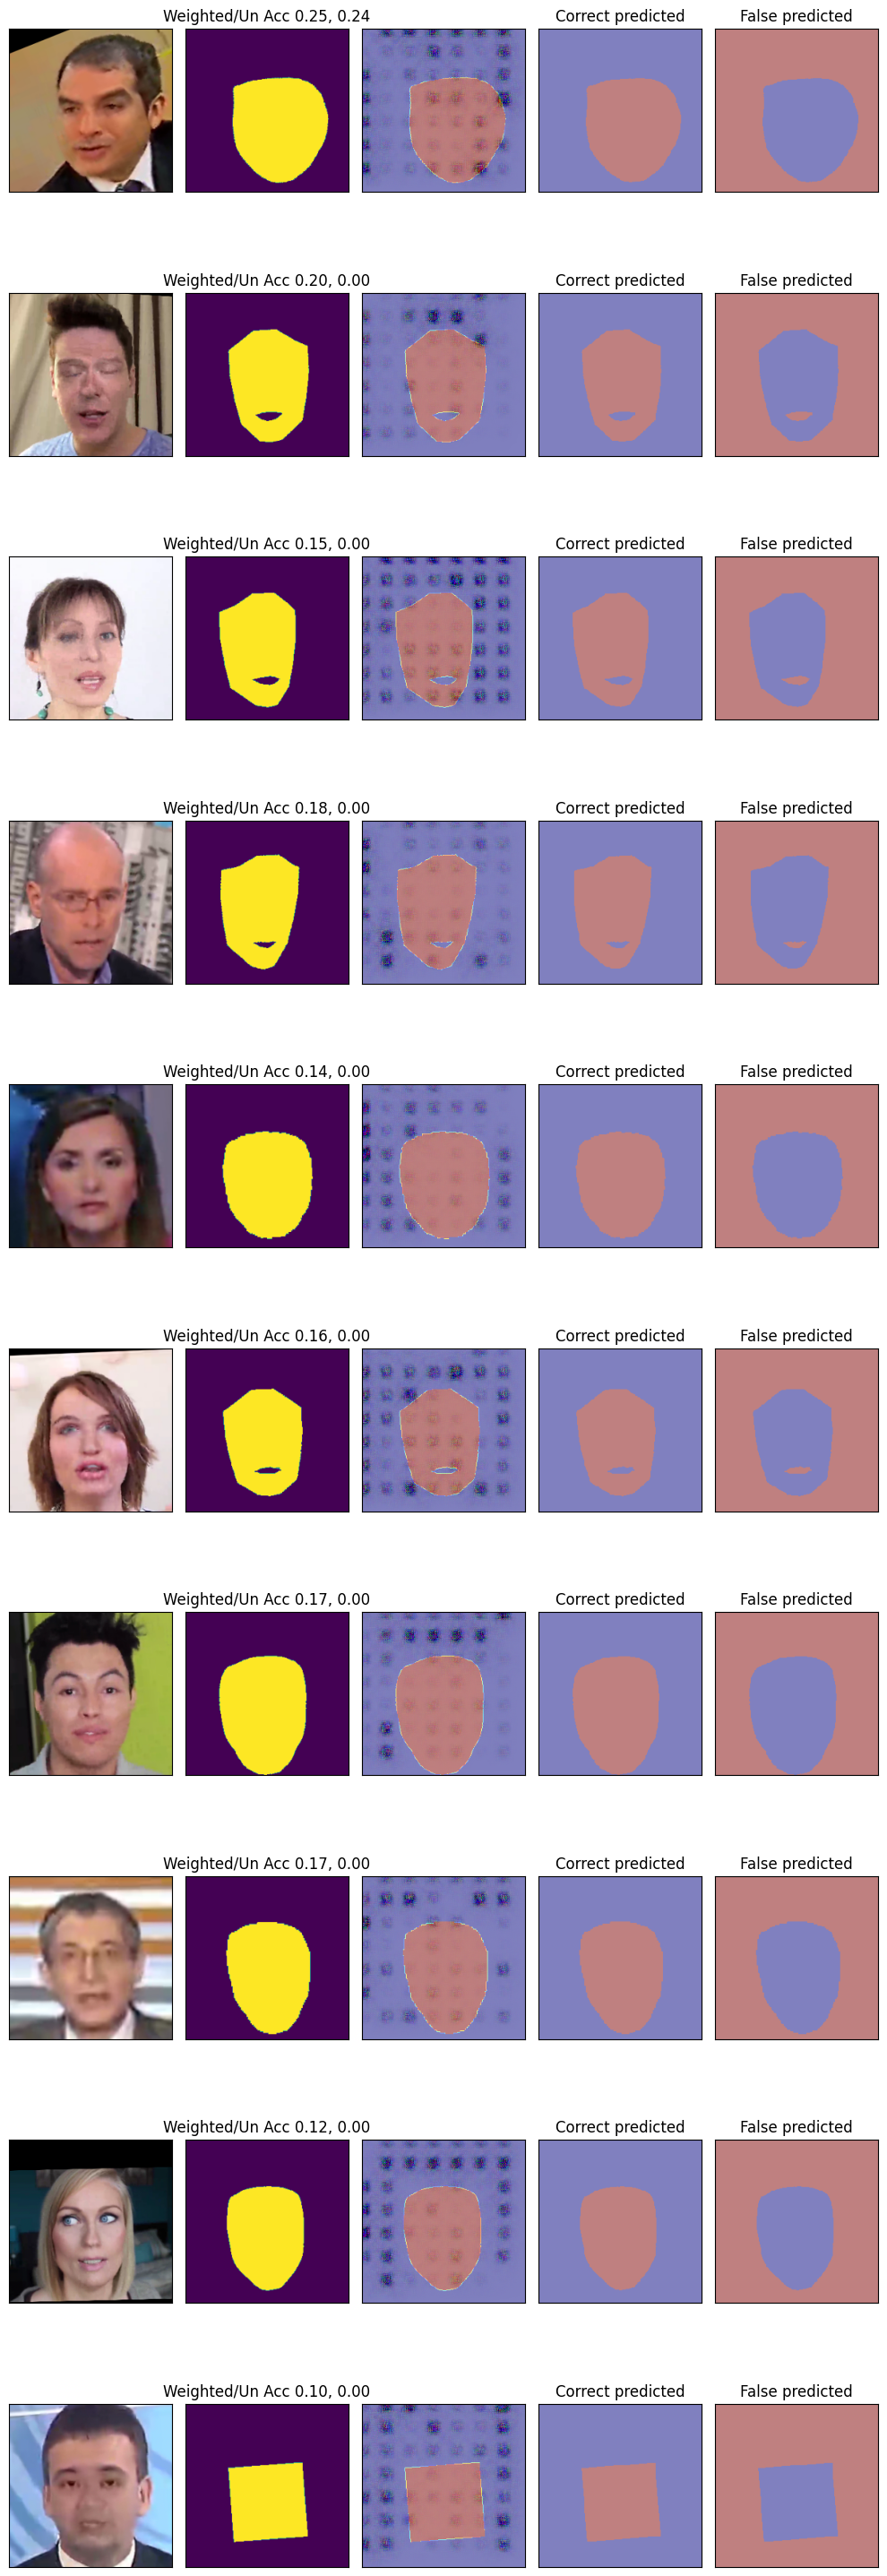

In [116]:
visualize_results(source='pickle', results_file=results_file, num_plots=10)